
# <span style="color:rgb(213,80,0)">Running Scenarios with Mantis</span>

## Start Mantis Server
-  Download the Tule River data

First, download the Tule River dataset from the repository (repo name).

-  Open a terminal and navigate to the configuration file directory

In your terminal or command prompt, navigate to the folder where the <samp>mantisConfig2.ini</samp> file is located. Do **not** include the filename in the path. For example:


<samp>> cd F:\\path\\to\\config\\directory</samp>

-  Start the Mantis server

Run the following command to start the Mantis server, specifying the configuration file:


 <samp>> F:\\github\\repo\\CPP\\Bin\\MantisServer.exe -c mantisConfig2.ini</samp>

-  Wait for the server to finish loading

The server will read the input data, and once initialization is complete, it will display a message indicating it is ready for use.

<p style="text-align:left">
   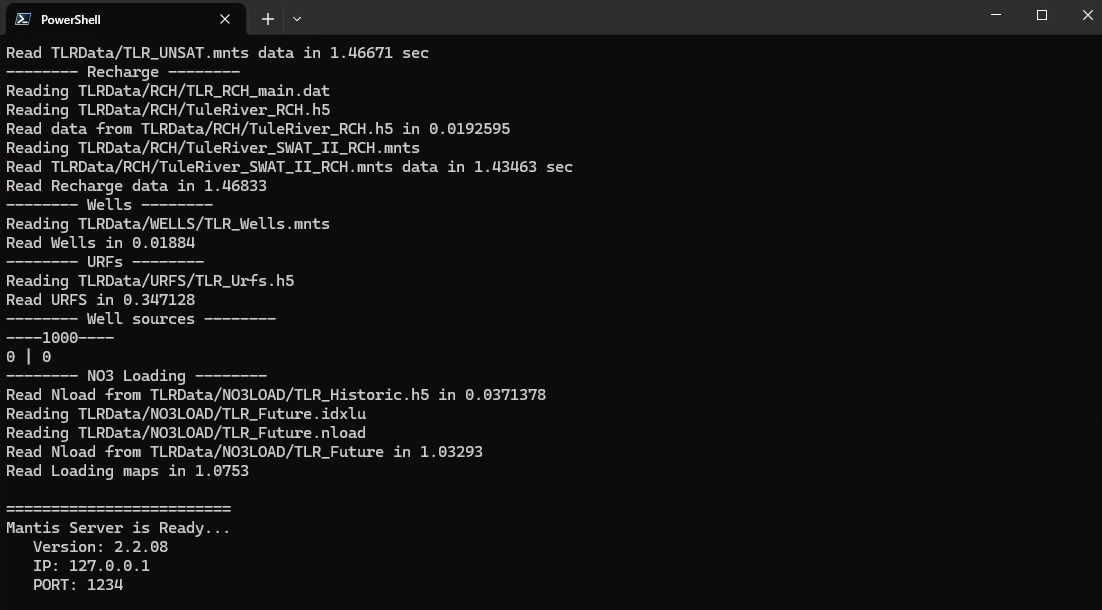
</p>

## Setup Matlab API
-  Add the MATLAB API functions to your path

The necessary functions for the MATLAB API are located in the [gwtools](https://github.com/UCD-GW-Nitrate/gwtools) repository.Make sure the folder containing these functions is included in your MATLAB path, for example:


In [1]:
addpath('G:\UCDAVIS\gwtools\Matlab\');


-  Initialize the Mantis input structure

Use the following command to initialize the <samp>scenario</samp> structure, which contains all available Mantis options:


In [2]:
scenario = MantisInputs;


-  Configure paths for client and temporary files

Before communicating with the Mantis server, specify the location of the Mantis client executable, as well as the paths for the temporary input and output files:


In [3]:
scenario.client = fullfile('G:\UCDAVIS\Mantis\CPP\BIN\MantisClient.exe');
scenario.infile = 'temp_inputfile.dat';
scenario.outfile = 'temp_output_file.dat';

## Run Scenarios with Mantis server
#### Set up common options

Start by configuring the options that are shared across all scenarios in this example.


<u>Specify the model area</u>


This dataset contains only one available area:


In [4]:
scenario.modelArea = 'TuleRiver';


<u>Choose a background map</u>


We can use either <samp>TuleRiver</samp> or  <samp>Townships</samp> as the background map:

-  <samp>TuleRiver</samp>  simulates the entire region.
-   <samp>Townships</samp>  limits the simulation to wells within specified townships.

In [5]:
scenario.bMap = 'TuleRiver';


<u>Define the region(s)</u>


Provide a list of geographical entities that correspond to the selected background map. For <samp>TuleRiver</samp> background map, only one region is available:


In [6]:
scenario.Regions = {'TuleRiver'};


<u>Set the flow scenario, well type and porosity</u>


This example includes only one flow scenario and one well type. There are 6 porosity values available from 10 to 60% with 10% increment.{10, 20,...60}


In [7]:
scenario.flowScen = 'TuleRiver';
scenario.wellType = 'VI';
scenario.por = 10; % Porosity (in percent)


<u>Configure unsaturated zone options</u>


Two options are available for the unsaturated zone scenario:

-  CVHM2\_MAR24 Based on unsaturated depth simulated by CVHM2
-  C2VSIM\_MAR24 Based on unsaturated depth simulated by C2VSim

Also, specify the water content (as a fraction). For example, to use 20%:


In [8]:
scenario.unsatScen = 'C2VSIM_MAR24';
scenario.unsatWC = 0.2;


<u>Define the simulation period</u>


Set the start and end years for the simulation:


In [9]:
scenario.startSimYear = 1945;
scenario.endSimYear = 2100;

### Run with historic loading only

In this first run we will use the historic loading where the loading from 1945 to 2050 is defined with 15 years increments. After 2050 the loading is constant and equal to 2050.


As there is no loading blend we set the parameter loadScen and no transition loading:


In [10]:
scenario.loadScen = 'Historic';
scenario.LoadTransitionName = 'NONE';


Now we are ready to run the first scenario


To run the simulation execute the following command:


In [11]:
[btc_historic, tf] = runMantis(scenario);

### Run with future scenario only

Here we will use the future cyclical loading for the past and future.


In [12]:
scenario.loadScen = 'Future';
scenario.LoadTransitionName = 'NONE';
[btc_future, tf] = runMantis(scenario);

### Run with blended historic and future loading

In this scenario we will start with the historic loading from 1945 to 2030. However we will blend the future loading gradually from 2010 until 2030. After 2030 the loading corresponds to future.


In [13]:
scenario.loadScen = 'Future';
scenario.LoadTransitionName = 'Historic';
scenario.LoadTransitionStart = 2010;
scenario.LoadTransitionEnd = 2030;
[btc_blend, tf] = runMantis(scenario);


Before ploting we will calculate a few characteristic percentiles of the breakthrough curve distributions for the ensamble of the Tule River wells


In [14]:
prc_values = [25 50 75 90 95];
prc_historic = prctile(btc_historic, prc_values);
prc_future = prctile(btc_future, prc_values);
prc_blend = prctile(btc_blend, prc_values);


The following snippet plots the percentiles for the previous simulations as stacked plot



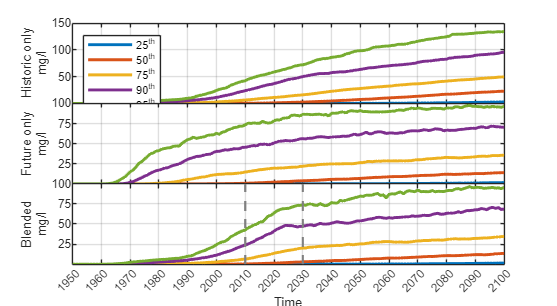

In [15]:
figure('Position',[100 100 1000 550])
clf
tiledlayout(3,1,'TileSpacing','none')
xtik = 1950:10:2100;

nexttile
plot(1946:2100,prc_historic','LineWidth',2)
grid on
xlim([1950 2100])
xticks(xtik);
xticklabels('');
yticks(50:50:200)
ylabel({'Historic only','mg/l'})
legend({'25^{th}', '50^{th}', '75^{th}', '90^{th}', '95^{th}'},'Location','northwest')

nexttile
plot(1946:2100,prc_future','LineWidth',2)
grid on
xlim([1950 2100])
xticks(xtik);
xticklabels('');
yticks(25:25:100)
ylabel({'Future only','mg/l'})

nexttile
plot(1946:2100,prc_blend','LineWidth',2)
grid on
xlim([1950 2100])
xticks(xtik);
yticks(25:25:100)
ylabel({'Blended','mg/l'})
xlabel('Time')
hold on
plot([2010 2010], [0 100],'--','Color',0.5*ones(1,3),'LineWidth',1.5)
plot([2030 2030], [0 100],'--','Color',0.5*ones(1,3),'LineWidth',1.5)

In [16]:
%print -dpng -r600 TLR_btc_01

### Blend historic and future loading with uniform reduction

In [17]:
scenario.loadScen = 'Future';
scenario.LoadTransitionName = 'Historic';
scenario.LoadTransitionStart = 2010;
scenario.LoadTransitionEnd = 2030;
scenario.Crops = [-9 0.5];
scenario.startRed = 2031;
scenario.endRed = 2041;
[btc_reduction, tf] = runMantis(scenario);

In [18]:
prc_reduction = prctile(btc_reduction, prc_values);


Compare the BAU with the half reduction



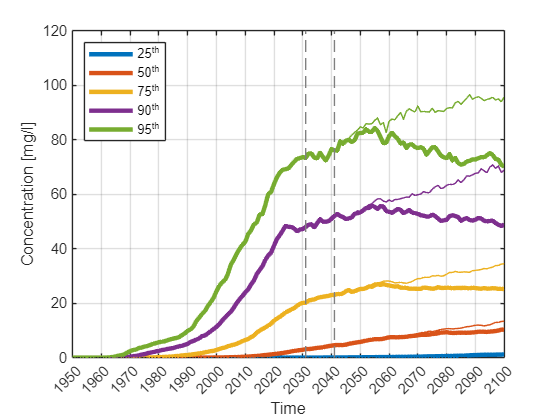

In [19]:
figure()
clf
plot(1946:2100,prc_reduction','linewidth',3)
ax = gca;
ax.ColorOrderIndex = 1;
hold on
plot(1946:2100,prc_blend','LineStyle','-','linewidth',1)
grid on
xlim([1950 2100])
plot([2031 2031], [0 120],'--','Color',0.5*ones(1,3))
plot([2041 2041], [0 120],'--','Color',0.5*ones(1,3))
xticks([1950:10:2100])
xlabel('Time')
ylabel('Concentration [mg/l]')
legend({'25^{th}', '50^{th}', '75^{th}', '90^{th}', '95^{th}'},'Location','northwest')

### Run Mantis scenarios in a loop

Next we will run Mantis inside a loop where we simulate the scenarios BAU, half loading and zero loading.


The BAU and half loading have already been simulated in the previous snippets but the simulation period was set up to 2100.


To point out the long term effect of NPS we will repeat those simulations until 2500.


In [20]:
scenario.loadScen = 'Future';
scenario.LoadTransitionName = 'Historic';
scenario.LoadTransitionStart = 2010;
scenario.LoadTransitionEnd = 2030;

scenario.startRed = 2031;
scenario.endRed = 2041;
scenario.endSimYear = 2500;
reductions = [1 0.5 0];
for ii = 1:length(reductions)
    scenario.Crops = [-9 reductions(ii)];
    [btc_reduct_loop{ii,1}, tf] = runMantis(scenario);
end


Similary we calculate the percentiles in a loop


In [21]:
for ii = 1:length(reductions)
    prc_reduct_loop{ii,1} = prctile(btc_reduct_loop{ii,1}, prc_values);
end


Plot the long term effect of loading reduction



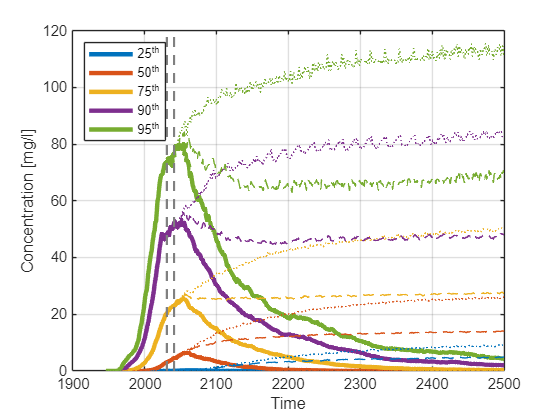

In [22]:
figure()
clf
plot(1946:2500,prc_reduct_loop{3,1}','linewidth',3)
ax = gca;
ax.ColorOrderIndex = 1;
hold on
plot(1946:2500,prc_reduct_loop{1,1}','LineStyle',':','linewidth',1)
ax = gca;
ax.ColorOrderIndex = 1;
hold on
plot(1946:2500,prc_reduct_loop{2,1}','LineStyle','--','linewidth',1)

plot([2031 2031], [0 120],'--','Color',0.5*ones(1,3),'linewidth',1.5)
plot([2041 2041], [0 120],'--','Color',0.5*ones(1,3),'linewidth',1.5)

grid on
xlabel('Time')
ylabel('Concentration [mg/l]')
legend({'25^{th}', '50^{th}', '75^{th}', '90^{th}', '95^{th}'},'Location','northwest')

In [23]:
%print -dpng -r600 TLR_reductions

### Run crop specific scenarios

In the following code section we will examine which crops are more influencial in the Tule River basin.


First we read the crop codes for the future loading


In [24]:
Cropcodes = readtable('TLR_exampleData\SWAT_LULC.csv');
head(Cropcodes,5)

      CODE            NAME          ID
    ________    ________________    __
    {'AGRB'}    {'Bush Berries'}    1 
    {'ALFA'}    {'Alfalfa'     }    2 
    {'ALMC'}    {'Cherries'    }    3 
    {'ALMD'}    {'Almonds'     }    4 
    {'ALMI'}    {'Pistachios'  }    5


First we will set up a few common scenario options.


We will blend the historic and future loading from 2010 to 2030, while the crop reductions will adapted from 2031 to 2041. The simulation will run until 2100.


In [25]:
scenario.loadScen = 'Future';
scenario.LoadTransitionName = 'Historic';
scenario.LoadTransitionStart = 2010;
scenario.LoadTransitionEnd = 2030;

scenario.startRed = 2031;
scenario.endRed = 2041;
scenario.endSimYear = 2100;


Run the Business as usuall (BAU)


In [26]:
prc_val = [50 75 90 95];
scenario.Crops = [-9 1];
[btc_bau, tf] = runMantis(scenario);
prc_bau = prctile(btc_bau, prc_val);


Now we are going Loop throug the crop codes to run the simulation with half and zero pollution for each crop.


First we create a table to hold the results which include the selected percentiles. Note that we do not keep the concentration breakthrough curves.


Since this is going to loop 57 times it is recomended to have Mantis run with as many threads as possible


In [27]:
vtype = cell(1,10);
vtype{1,1} = 'categorical';
for ii = 2:10
    vtype{1,ii} = 'double';
end
CropReductions = table('Size',[length(Cropcodes.ID),10],'VariableTypes',vtype, ...
    'VariableNames',{'CropName','CropId','half50','half75','half90','half95','zero50','zero75','zero90','zero95'});

for ii = 1:length(Cropcodes.ID)
    CropReductions.CropName(ii) = categorical(Cropcodes.NAME(ii));
    CropReductions.CropId(ii) = Cropcodes.ID(ii);
    scenario.Crops = [Cropcodes.ID(ii) 0.5];
    [btc_tmp, tf] = runMantis(scenario);
    prc_tmp = prctile(btc_tmp, [50 75 90 95]);
    CropReductions.half50(ii) = prc_bau(1,end) - prc_tmp(1,end);
    CropReductions.half75(ii) = prc_bau(2,end) - prc_tmp(2,end);
    CropReductions.half90(ii) = prc_bau(3,end) - prc_tmp(3,end);
    CropReductions.half95(ii) = prc_bau(4,end) - prc_tmp(4,end);

    scenario.Crops = [Cropcodes.ID(ii) 0.0];
    [btc_tmp, tf] = runMantis(scenario);
    prc_tmp = prctile(btc_tmp, [50 75 90 95]);
    CropReductions.zero50(ii) = prc_bau(1,end) - prc_tmp(1,end);
    CropReductions.zero75(ii) = prc_bau(2,end) - prc_tmp(2,end);
    CropReductions.zero90(ii) = prc_bau(3,end) - prc_tmp(3,end);
    CropReductions.zero95(ii) = prc_bau(4,end) - prc_tmp(4,end);

end


The influence of the crops is based to a large extend on the crop caverage.


We can read the future loading to extract information about the crop caverage area


In [28]:
nload = readMantis_NO3Load(fullfile('TLR_exampleData/TLRData/NO3LOAD/TLR_Future.h5'));


Count the number of raster cells for each crop


In [29]:
[CropCounts, CropIDs] = groupcounts(double(nload.LU));


Append the crop cell counts to the crop reduction table


In [30]:
CropReductions.CountCells = zeros(size(CropReductions,1),1);
for ii = 1:length(CropIDs)
    idx = find(CropReductions.CropId == CropIDs(ii));
    CropReductions.CountCells(idx) = CropCounts(ii);
end

### Combine Mantis with optimization

In [31]:
CropReductions_sorted = sortrows(CropReductions,{'CountCells'},{'descend'});
prc_crop = cumsum(sort(CropReductions.CountCells,'descend'))./length(nload.LU);

In [32]:
scenario.loadScen = 'Future';
scenario.LoadTransitionName = 'NONE';
scenario.LoadTransitionStart = 2010;
scenario.LoadTransitionEnd = 2030;

scenario.startRed = 2031;
scenario.endRed = 2041;
scenario.endSimYear = 2100;
scenario.Crops = [-9 1];
[btc_bau, tf] = runMantis(scenario);
prc_bau_opt = prctile(btc_bau, 5:5:95);

In [33]:
f = @(x)tlrobj(x,CropReductions_sorted.CropId(1:13),CropReductions_sorted.CountCells(1:13), scenario, prc_bau_opt(:,end));
gaoptions = optimoptions('gamultiobj','PlotFcn',"gaplotpareto","PopulationSize",100,'Display','iter','MaxGenerations',400, ...
    'MutationFcn','mutationadaptfeasible','CrossoverFcn',{@crossoverheuristic,0.7});
[x,fval] = gamultiobj(f, 13, [], [], [], [], 0*ones(1,13), 1*ones(1,13), gaoptions)


Save optimization results


In [34]:
save('gamultOptimResults','x','fval')

### Optimization results

Read the saved results


In [35]:
optim_res = load('gamultOptimResults.mat');

In [36]:
CropReductions_sorted.CropNameSort = CropReductions_sorted.CropName;
CropReductions_sorted.CropNameSort(2) = 'CWDA';
CropReductions_sorted.CropNameSort(4) = 'CWND';


Save it so that we can recreate the following plot without running Mantis


In [37]:
%save('CropReductions_sorted','CropReductions_sorted')
load('CropReductions_sorted','CropReductions_sorted')


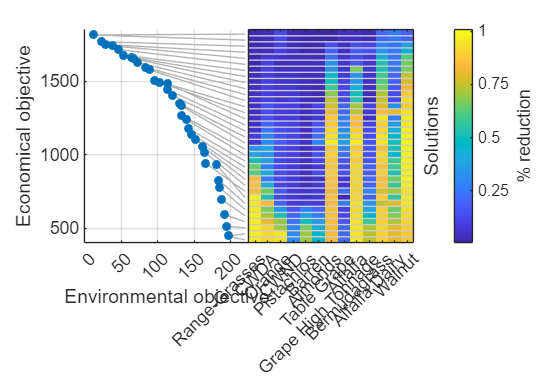

In [38]:
figure('Position',[100,100,1200,840])
clf
tiledlayout(1,2,"TileSpacing","none")

nexttile
fecon = -optim_res.fval(:,2)*2500/(1000*1000);
fenv = -optim_res.fval(:,1);
[cc, dd] = sort(fecon);
%scatter(fx, fy,'filled')
xlabel('Environmental objective')
ylabel('Economical objective')
grid on
xticks(0:50:200)
xlim([0 225])
ylim([400 1850])
hold on
px_end = 220;
py_end = linspace(420,1820,35);
for ii = 1:length(fenv)
    p1 = [fenv(dd(ii)) fecon(dd(ii))];
    p2 = [px_end py_end(ii)];
    ll = pdist([p1;p2]);
    u = interp1q([30;210],[0.1;0.05],ll);
    pp1 = (1-u).*p1 +u.*p2;
    %pp2 = 0.1.*p1 +0.9.*p2;
    plot([p1(1) px_end], [p1(2) py_end(ii)],'Color', [0.7 0.7 0.7], 'LineStyle','-','LineWidth',0.5)
end
%plot(220*ones(35,1),linspace(420,1820,35),'.')
scatter(fenv, fecon,'filled')
set(gca,'FontSize',12);

nexttile
image(255*(1-optim_res.x(dd,:)))
axis xy
hold on
for ii = 1:34
    plot([0 14],[ii+0.5 ii + 0.5],'Color',[0.8 0.8 0.8])
end
view(0,90)
ax = gca;
ax.YAxisLocation = 'right';
xticks(1:13)
xticklabels(CropReductions_sorted.CropNameSort)
ax.YTick = [];
ax.XTickLabelRotation = 45;
ylabel('Solutions','FontSize',12)
h = colorbar;
h.Ticks = linspace(0,255,5);
h.TickLabels = {'0','0.25','0.5','0.75','1'};
h.Label.String = '% reduction';
h.Label.FontSize = 12;
set(gca,'FontSize',12);

In [39]:
%print -dpng -r600 OptimResults